In [44]:
import pandas as pd
import numpy as np
import duckdb
import dotenv
import os

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, SplineTransformer, FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge, GammaRegressor, TweedieRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_percentage_error

In [45]:
dotenv.load_dotenv()

True

In [46]:
md_token = os.environ['MOTHERDUCK_TOKEN']


con = duckdb.connect(f'md:?motherduck_token={md_token}')
df = con.query('select * from bike.staging.fact_trips_feature_store where station_trips is not null and station_trips > 0;').df()
df['time'] = (df.toronto_local_time - df.toronto_local_time.min()).dt.days
df['active_to'] = df.toronto_local_time.dt.date.astype(str).isin(['2021-05-15', '2021-05-16', '2021-05-22', '2021-05-23'])



df_train = df.query("toronto_local_time < '2024-08-01'")
df_test = df.query("toronto_local_time >= '2024-08-01'")

y_train = df_train.station_trips.values
y_test = df_test.station_trips.values


<Axes: xlabel='toronto_local_time'>

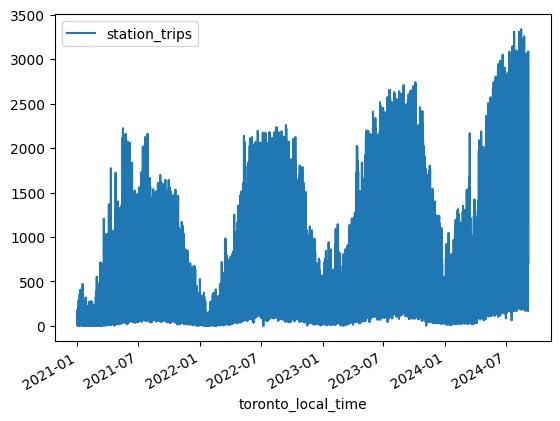

In [47]:
df.plot(x='toronto_local_time', y='station_trips')

In [48]:
df.head()

,toronto_local_time,year,month,month_pct,day_of_year,day_of_week,hour,station_trips,temperature_2m,relative_humidity_2m,apparent_temperature,cloud_cover,wind_speed_10m,precipitation,snowfall,time,active_to
0,2021-01-01 00:00:00,2021,January,0.032258,1,Friday,0,52,-0.5,74.0,-5.2,17.0,13.1,0.0,0.0,0,False
1,2021-01-01 01:00:00,2021,January,0.032258,1,Friday,1,72,-1.3,78.0,-5.7,9.0,11.6,0.0,0.0,0,False
2,2021-01-01 02:00:00,2021,January,0.032258,1,Friday,2,23,-2.0,81.0,-6.6,4.0,12.2,0.0,0.0,0,False
3,2021-01-01 03:00:00,2021,January,0.032258,1,Friday,3,13,-2.6,83.0,-7.0,3.0,11.4,0.0,0.0,0,False
4,2021-01-01 04:00:00,2021,January,0.032258,1,Friday,4,18,-3.1,85.0,-7.5,3.0,11.0,0.0,0.0,0,False


In [49]:
categorical_features = ['month','day_of_week']
numerical_features = ['year','month_pct', 'temperature_2m', 'relative_humidity_2m','apparent_temperature','cloud_cover','wind_speed_10m', 'precipitation','snowfall']
nonlinear_features = ['hour']

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('interactions', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])


nonlinear_pipeline = Pipeline([
    ('splines', SplineTransformer(include_bias=True, extrapolation='periodic', knots=np.arange(0, 24, 2.5).reshape(-1, 1)))
])

time_pipeline = Pipeline([
    ('time', SplineTransformer(extrapolation='linear'))
])


ct = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features),
    ('nonlinear', nonlinear_pipeline, nonlinear_features), 
    ('time', time_pipeline, ['time'])
    
], remainder='drop')


model = Pipeline([
    ('column_transformer', ct), 
    ('knnImputer', KNNImputer(n_neighbors=10) ),
    ('scaler', StandardScaler()),
    ('ridge', TweedieRegressor(max_iter=10_000))
])

params = {
    'ridge__alpha': 2**np.linspace(-5, 5, 10),
    'ridge__power': [0, 1, 1.25, 1.5, 1.75, 2, 3], 
    'column_transformer__time__time__knots': ['quantile','uniform'], 
    'column_transformer__time__time__n_knots': [5, 10, 20, 50], 
}

rmse = make_scorer(root_mean_squared_error, greater_is_better=False)
mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
scorers = {'rmse':rmse, 'mape': mape}

gscv = GridSearchCV(
    estimator=model,
    param_grid=params, 
    cv=TimeSeriesSplit(n_splits=3), 
    scoring=scorers,
    n_jobs = -1, 
    verbose=4, 
    refit='mape'
)

fit = gscv.fit(df_train, y_train)

Fitting 3 folds for each of 1400 candidates, totalling 4200 fits
[CV 1/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125, ridge__power=0; mape: (test=-2.397) rmse: (test=-372.203) total time=   0.3s
[CV 2/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125, ridge__power=0; mape: (test=-2.659) rmse: (test=-709.680) total time=   0.6s
[CV 1/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125, ridge__power=1.5; mape: (test=-0.847) rmse: (test=-621.930) total time=   0.6s
[CV 3/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125, ridge__power=0; mape: (test=-1.436) rmse: (test=-417.534) total time=   0.9s
[CV 1/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03

/Users/demetripananos/Repos/bike/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.04171374544281358, ridge__power=1.25; mape: (test=-0.847) rmse: (test=-651.161) total time=   1.0s
[CV 3/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.03125, ridge__power=1; mape: (test=-2.341) rmse: (test=-3027.095) total time=   3.0s
[CV 2/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.04171374544281358, ridge__power=1.25; mape: (test=-0.657) rmse: (test=-605.144) total time=   1.2s
[CV 2/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.04171374544281358, ridge__power=1.5; mape: (test=-0.587) rmse: (test=-528.839) total time=   0.9s
[CV 1/3] END column_transformer__time__time__knots=quantile, column_transformer__time__time__n_knots=5, ridge__alpha=0.04171374544281358, ridge

KeyboardInterrupt: 

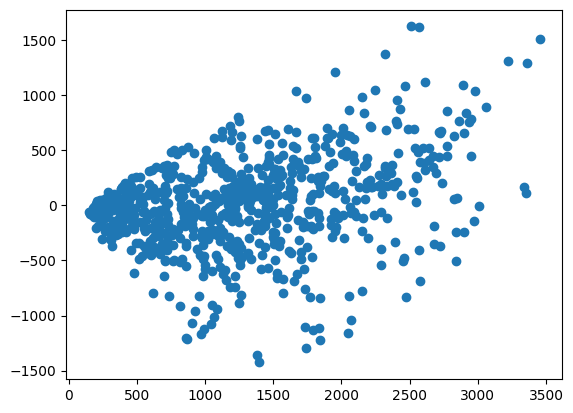

In [ ]:
ypred = fit.predict(df_test)

plt.scatter(ypred, ypred-y_test)

In [ ]:
fit.best_score_

np.float64(-0.6925217362394207)

In [ ]:
mean_absolute_percentage_error(y_test, ypred)

np.float64(0.2766889578243777)

In [ ]:
df_test['pred'] = ypred

/var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/ipykernel_31513/3400341002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred'] = ypred


<Axes: xlabel='toronto_local_time', ylabel='station_trips'>

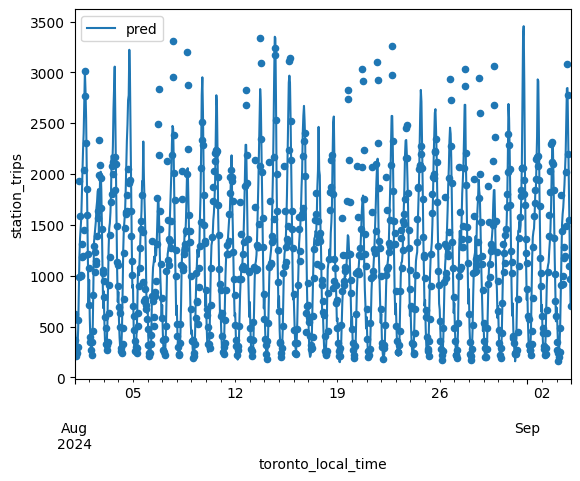

In [ ]:
ax = df_test.plot(x='toronto_local_time', y='pred')
df_test.plot.scatter(x='toronto_local_time', y='station_trips', ax = ax)